In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

### Preparing the data

In [2]:
def Sun_time(files_dir):
    # get Sunrise and Sunset time
    df = pd.read_excel(files_dir)
    df = df.loc[(df['Year'] >= 2017) &(df['Year'] <= 2020)]
    df['SolarNoon'] = (df['Sunrise']+df['Sunset'])/2 # calculate the solar noon time
    # df =  df.loc[:, ['Year', 'Month', 'Day','Sunrise','Sunset','SolarNoon']]
    df =  df.loc[:, ['Year', 'Month', 'Day','SolarNoon']]
    return df

In [3]:
def SolarData(files_dir):
    df = pd.read_excel(files_dir)
    df = df.loc[(df['Year'] >= 2017) &(df['Year'] <= 2020)]
    
    df['Date'] =  df['DateTime'].dt.date
    #df.index = df['DateTime']
    #del df['DateTime']
    
    # Add a Hot Panel Variable
    count = round(len(df)* 0.01)
    GGHI = df.sort_values(by = ['GHI'], ascending = False).reset_index(drop = True)
    GGHI = GGHI.iloc[:count]
    GGHI = GGHI[len(GGHI)-1:]['GHI'].values[0]
    df['Hot_Panel'] = df.apply(lambda x:1 if (x.GHI>=GGHI and x._THI>70) else(0), axis=1)
    
     # Add a ClearSky_Ratio Variable
#     df['ClearSky_Ratio'] = df.apply(lambda x:x['GHI']/x['GHI_TOA'] if (x['GHI_TOA']>10 and x['GHI']>10) else(0), axis=1)
    
    df = df.drop_duplicates(['Year', 'Month','Day', 'Hour']).reset_index(drop = True)

    return df

In [4]:
# Merge Suninfo file and solar data file
def merge(df1, df2):
    df = pd.merge(df2, df1, on = ['Year', 'Month','Day']) 
    # Add a Suntime Variable
    df['Suntime'] = df['Hour']-df['SolarNoon']
    
    df = df.dropna(axis=0, how='any', inplace=False)
    
    df.index = df['DateTime']
    del df['DateTime']
    return df

In [5]:
files_dir = "C:/Users/zhongj/Desktop/Task2_Data/Sun_Info/Sun_Info_zone_K.xlsx" 
df1 = Sun_time(files_dir)

In [6]:
files_dir2 = "C:/Users/zhongj/Desktop/Task2_Data/Final_Zonal_Data_for_Modeling" 
os.chdir(files_dir2)
df2 = SolarData('ZoneK_FinalData.xlsx')

In [7]:
df = merge(df1, df2)

In [8]:
files_dir3 = "C:/Users/zhongj/Desktop/Task2_PPT/modeling" 
os.chdir(files_dir3)

### Define some funtions

###### Stat

In [9]:
def RMSE_MAPE_MAD(Result):

    df = Result.copy()
    df['err'] =  abs(df["BTM_hat"] - df["BTM"])
    df1 = df[df["BTM"] > 0]
    
    sqr_error = df1['err']**2
    RMSE = np.sqrt(np.mean(sqr_error)) #RMSE
    
    MAD = np.mean(df1['err']) # MAD
   
    # MAPE:
    df2 = df[df["BTM"] >= 0.2]
    df2['err2'] = df2['err']/df2['BTM']
    
    MAPE= np.mean(df2['err2'])*100
    
    RMSE = np.round(RMSE,4)
    MAPE = np.round(MAPE,2)
    MAD = np.round(MAD,4)    
    
    return RMSE, MAPE, MAD

In [10]:
def RMSE_MAPE_MAD_DT_TABLE(Result):
    y_hat = Result["BTM_hat"]
    y =  Result["BTM"]
    
    df_RMSE = pd.DataFrame()
    df_MAPE = pd.DataFrame()
    df_MAD = pd.DataFrame()
    for i in range(1,13):
        RMSE_list = []
        MAPE_list = []
        MAD_list = []
        for j in range(0, 24):
            df = Result.loc[(Result['Month'] == i)&(Result['Hour'] == j)]
            
            RMSE, MAPE, MAD = RMSE_MAPE_MAD(df)
            RMSE_list.append(RMSE)
            MAPE_list.append(MAPE)
            MAD_list.append(MAD)

        df_RMSE["%d"%(i)] = RMSE_list
        df_MAPE["%d"%(i)] = MAPE_list
        df_MAD["%d"%(i)] = MAD_list
        
    return df_RMSE, df_MAPE, df_MAD

In [11]:
def change_data_structure(df_RMSE, df_MAPE, df_MAD):
    RMSE_list = np.array(df_RMSE)
    RMSE_list = RMSE_list.tolist()
    
    MAPE_list = np.array(df_MAPE)
    MAPE_list = MAPE_list.tolist()
    
    MAD_list = np.array(df_MAD)
    MAD_list = MAD_list.tolist()
    
    dic_list = {}
    dic_list['RMSE_list'] = RMSE_list
    dic_list['MAPE_list'] = MAPE_list
    dic_list['MAD_list'] = MAD_list
    
    return dic_list

In [12]:
def contour_plot(key, dic_list, dataset_name): 
    x = list(range(1,13)) #horizontal axis (column names)
    y =list(range(6,21)) # vertical axis (Row names)
    
    X,Y = np.meshgrid(x,y) # get x-axis and y-axis
    
    #plot:
    fig, ax = plt.subplots(1,1,figsize = (15,10))
    ax.contourf(X,Y, dic_list[key], 10, cmap = plt.cm.spring)
    c = plt.contour(X,Y, dic_list[key], 10, colors = 'black' )  
    #setting:
    ax.clabel(c, inline = True, fontsize = 10)
    ax.set_ylabel('Hour')
    ax.set_xlabel('Month')
    ax.set_title('%s_%s_Contour_Plot'%(dataset_name, key))
        

    # plt.show() # show plot in python
    # save plot in current file dir
    fig.savefig('%s_%s_Contour_Plot'%(dataset_name, key),bbox_inches="tight")
    
    # 3 ways to close plots:
        # (seems like it doesn't work, but I put them here in case it works)
    plt.cla()
    plt.clf()
    plt.close(fig)

###### Scatter Plots

In [13]:
def Fitted_Actual_Scatter(Result, dataset_name):
    
    y_hat = Result["BTM_hat"]
    y =  Result["BTM"]
    
    fig, ax = plt.subplots(1, 1, figsize= (10,10))
    
    #plot:
    ax.scatter(y_hat, y, s=0.9, alpha = 0.5)
    ax.plot((0,0.7), (0, 0.7),ls = '--', c='k')
        #Setting:
    ax.grid(linestyle='--', linewidth='1', color = 'grey', alpha =0.1)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.set_ylabel("Actual (MW)", fontsize=13)
    ax.set_xlabel("Predicted (MW)", fontsize=13)
    ax.set_title("ZoneK %s Dataset - Predicted vs Actual"%dataset_name)
    
    fig.savefig('ZoneK - %s Fitted vs Actual Scatter Plot'%dataset_name, bbox_inches="tight")

    plt.show()

In [14]:
def Fitted_Actual_Scatter_Hourly(Result, Hr, dataset_name):

    # predicted data:
    df = Result.loc[(Result['Hour'] == Hr)]

    # Actual data:
    y =  df["BTM"]
    y_hat = df["BTM_hat"]
    
    fig, ax = plt.subplots(1, 1, figsize= (15,5))
    
    # Fitted vs. Actual scatter plots:
    ax.scatter(y, y_hat, s=0.9, alpha = 0.5)
    ax.plot((0,0.7), (0, 0.7),ls = '--', c='k')
        #Setting:
    ax.grid(linestyle='--', linewidth='1', color = 'grey', alpha =0.1)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.set_xlabel("Actual (MW)", fontsize=13)
    ax.set_ylabel("Fitted (MW)", fontsize=13)
    ax.set_title("ZoneK %s Dataset - Fitted vs Actual at Hour%d"%(dataset_name, Hr))
    
    fig.savefig("ZoneK - %s Fitted vs Actual at Hour%d"%(dataset_name, Hr), bbox_inches="tight")

    plt.plot()

###### Bar Plots

In [15]:
def Prediction_Error_Bar(Result, dataset_name):
    
    fig, ax = plt.subplots(2, 1, figsize= (15,10))
    
    # Fitted vs. Actual bar plots:
    df = Result.reset_index()
    df['diff'] = df['BTM_hat'] - df['BTM']
    
    #Plot
    ax[0].bar(df['DateTime'], df['diff'], alpha= 0.5)
      #Setting
    ax[0].set_ylabel('Predicted Error')
    ax[0].grid(linestyle='--', linewidth='1', color = 'grey', alpha =0.2)
    ax[0].spines['top'].set_color('none')
    ax[0].spines['right'].set_color('none')
    ax[0].set_title("ZoneK - %s Difference between Fitted and Actual"%dataset_name)
    
    # In details:
    df = df[-300:]
    ax[1].bar(df['DateTime'], df['diff'], alpha= 0.9)
    ax[1].set_ylabel('Predicted Error')
    ax[1].grid(linestyle='--', linewidth='1', color = 'grey', alpha =0.2)
    ax[1].spines['top'].set_color('none')
    ax[1].spines['right'].set_color('none')
    ax[1].set_title("Magnified above plot")
    
    fig.savefig('ZoneK - %s Prediction Error Bar Plot'%dataset_name, bbox_inches="tight")

    plt.show()

In [16]:
def Daily_Average_Prediction_Error_Bar(Result, dataset_name):
    
    fig, ax = plt.subplots(2, 1, figsize= (15,10))
    
    # Fitted vs. Actual bar plots:
    df = Result.reset_index()
    
    df['Date'] =  df['DateTime'].dt.date
    df['Hour'] =  df['DateTime'].dt.hour
    
    df['diff'] = df['BTM_hat'] - df['BTM']
    df['diff'] =  abs(df['diff'])
    
    df = df.loc[(df['Hour']>=8)&(df['Hour']<=17)]
    df = df.groupby(['Date']).mean()
    df = df.reset_index()
    
    #Plot
    ax[0].bar(df['Date'], df['diff'], alpha= 0.9)
      #Setting
    ax[0].set_ylabel('Predicted Error')
    ax[0].grid(linestyle='--', linewidth='1', color = 'grey', alpha =0.2)
    ax[0].spines['top'].set_color('none')
    ax[0].spines['right'].set_color('none')
    ax[0].set_title("ZoneK - %s  Average Absolute Prediction Error between 8am to 5pm"%dataset_name)
    
    # In details:
    df = df[-100:]
    ax[1].bar(df['Date'], df['diff'], alpha= 0.9)
    ax[1].set_ylabel('Predicted Error')
    ax[1].grid(linestyle='--', linewidth='1', color = 'grey', alpha =0.2)
    ax[1].spines['top'].set_color('none')
    ax[1].spines['right'].set_color('none')
    ax[1].set_title("Magnified above plot")
    
    fig.savefig('ZoneK - %s Daily Average Prediction Error Bar Plot'%dataset_name, bbox_inches="tight")

    plt.show()

In [17]:
def Daily_Max_Prediction_Error_Bar(Result, dataset_name):
    
    fig, ax = plt.subplots(2, 1, figsize= (15,10))
    
    # Fitted vs. Actual bar plots:
    df = Result.reset_index()
    
    df['Date'] =  df['DateTime'].dt.date
    df['Hour'] =  df['DateTime'].dt.hour
    
    df['diff'] = df['BTM_hat'] - df['BTM']
    df['diff'] =  abs(df['diff'])
    
    df = df.groupby(['Date']).max()
    df = df.reset_index()
    
    #Plot
    ax[0].bar(df['Date'], df['diff'], alpha= 0.9)
      #Setting
    ax[0].set_ylabel('Predicted Error')
    ax[0].grid(linestyle='--', linewidth='1', color = 'grey', alpha =0.2)
    ax[0].spines['top'].set_color('none')
    ax[0].spines['right'].set_color('none')
    ax[0].set_title("ZoneK - %s  Maximum Absolute Prediction Error"%dataset_name)
    
    # In details:
    df = df[-100:]
    ax[1].bar(df['Date'], df['diff'], alpha= 0.9)
    ax[1].set_ylabel('Predicted Error')
    ax[1].grid(linestyle='--', linewidth='1', color = 'grey', alpha =0.2)
    ax[1].spines['top'].set_color('none')
    ax[1].spines['right'].set_color('none')
    ax[1].set_title("Magnified above plot")
    
    fig.savefig("ZoneK - %s  Maximum Absolute Prediction Error"%dataset_name, bbox_inches="tight")

    plt.show()

###### daily_outlook

In [18]:
def daily_outlook(Result, dataset_name, month):
    Months = ['January','February','March','April','May','June','July','August','September','October','November','December']
   
    df = Result.reset_index()
    df['Year'] =  df['DateTime'].dt.year
    df['Month'] =  df['DateTime'].dt.month
    df['Day'] =  df['DateTime'].dt.day
    df.index = df['DateTime']
    
    year = list(df['Year'].unique())

    df = df.loc[(df['Year'] ==  year[-1]) &(df['Month'] ==  month)]
    y = df['BTM']
    y_hat = df['BTM_hat']
    
    fig, ax = plt.subplots(2, 1, figsize= (15,12)) #Setting
    
        #Plot:
    ax[0].plot(y)
    ax[0].plot(y_hat)
        #Setting:
    ax[0].legend(['Actual', 'Predicted'])
    ax[0].grid(linestyle='--', linewidth='1', color = 'grey', alpha =0.2)
    ax[0].spines['top'].set_color('none')
    ax[0].spines['right'].set_color('none')
    ax[0].set_title("ZoneK %s Dataset - Predicted vs Actual in %s"%(dataset_name, Months[month-1]))
      
    
    # Look at the details: 
        #Data:
    df2 = df.loc[(df['Day']>=10) &(df['Day']<=20)]
    y2 = df2['BTM']
    y_hat2 = df2['BTM_hat']

        #Plot:
    ax[1].plot(y2)
    ax[1].plot(y_hat2)
        #Setting
    ax[1].legend(['Actual', 'Predicted'])
    ax[1].grid(linestyle='--', linewidth='1', color = 'grey', alpha =0.2)
    ax[1].spines['top'].set_color('none')
    ax[1].spines['right'].set_color('none')
    ax[1].set_title("Day10 to Day20 in %s"%(Months[month-1]))
        
    fig.savefig('ZoneK - %s Fitted vs Actual Daily Outlook in %s'%(dataset_name, Months[month-1]), bbox_inches="tight")

    plt.show()

### Ramping behavior

In [19]:
import warnings
warnings.filterwarnings('ignore')
#hour_diff: ramping interval

def ramping(Result, hour_diff, HB, HE):
    
    df = Result.reset_index()
    df['Year'] =  df['DateTime'].dt.year
    df['Month'] =  df['DateTime'].dt.month
    df['Day'] =  df['DateTime'].dt.day
    df.index = df['DateTime']
    df = df.loc[(df['Hour'] >= HB) &(df['Hour'] <= HE)] #time range
    
    grouped = df.groupby(['Year', 'Month', 'Day'])
    
    year = list(df['Year'].unique())
    month =list(df['Month'].unique())
    
    df_diff1 = pd.Series()
    df_diff2 = pd.Series()
    
    #get differnce of 'hour_diff' days in each month and each year:
    for i in year:
        for j in month:
            day = list(df[(df['Year'] == i) & (df['Month'] == j)]['Day'].unique())
            for k in day:
                df2 = grouped.get_group((i,j,k))
                df2_1 = df2.loc[:, 'BTM'].reset_index(drop = True)
                df3 = df2_1.diff(hour_diff)
                df3 = df3.dropna(axis=0, how='any', inplace=False)
                df_diff1 = pd.concat([df_diff1, df3], ignore_index = True) 
                
                df2_2 = df2.loc[:, 'BTM_hat'].reset_index(drop = True)
                df4 = df2_2.diff(hour_diff)
                df4 = df4.dropna(axis=0, how='any', inplace=False)
                df_diff2 = pd.concat([df_diff2, df4], ignore_index = True) 
                
    return df_diff1,df_diff2

In [55]:
import scipy.stats as stats
import matplotlib.ticker as mtick

 
def ramping_plot(df, dataset_name, hour_diff, HB, HE):
    
    df2, df3 = ramping(df, hour_diff, HB, HE)
    
    # 3 sigma
    mean1 = np.mean(df2)
    std1 = np.std(df2)
    threshhold1 = mean1 - 3 *std1
    threshhold2 = mean1 + 3 *std1
    
    # 3 sigma
    mean2 = np.mean(df3)
    std2 = np.std(df3)
    threshhold3 = mean2 - 3 *std2
    threshhold4 = mean2 + 3 *std2
    
    #plot:
    fig, ax = plt.subplots(1,1,figsize = (15,8))
    
    plt.hist(df2, bins= 50, rwidth=0.95, log = True, weights=np.ones(len(df2))/len(df2), label = 'Actual: %d'%len(df2), alpha = 0.7)
    
    plt.hist(df3, bins= 50, rwidth=0.95, log = True, weights=np.ones(len(df3))/len(df3), label = 'Predicted: %d'%len(df3), alpha = 0.6)
    
    
    #setting:
    ax.set_ylabel('Log-scaled of counts ')
    ax.set_xlabel('Changes')
    ax.set_title('ZoneK %s Dataset - BTM %dhr Ramping Distribution (%dam -%dpm)'%(dataset_name, hour_diff, HB, HE))
    ax.grid(axis='y')
    ax.set_facecolor('#d8dcd6')
    xticks = mtick.PercentFormatter(xmax=1, symbol='%', is_latex=False)
    ax.xaxis.set_major_formatter(xticks)
    
    plt.axvline(threshhold1, ls = '--', c = 'green', label = 'Actual 3-sigma')
    plt.axvline(threshhold2, ls = '--', c = 'green')
    plt.legend()
    
    plt.axvline(threshhold3, ls = '--', c = 'red', label = 'Predicted 3-sigma')
    plt.axvline(threshhold4, ls = '--', c = 'red')
    plt.legend()

    
    plt.show() # show plot in python
    # save plot in current file dir
    fig.savefig('%s_BTM_%dhr_ramping_behavior'%(dataset_name, hour_diff), bbox_inches="tight")
    
    # 3 ways to close plots:
        # (seems like it doesn't work, but I put them here in case it works)
    plt.cla()
    plt.clf()
    plt.close(fig)

###### Combine the predicted results of hourly models

In [21]:
def model_pred(df, models, HB, HE):
   
    y_hat_df = pd.DataFrame(columns = ['DateTime', 'BTM_hat'])

    for i in range(HB, HE+1):
        model_data = df.loc[(df['Hour'] == i)]

        X =  model_data.iloc[:, 6:]

        y_hat =  models[i].predict(X) #using the model
        
        y_hat = y_hat.apply(lambda x: 0 if x<0 else(x))

        y_hat = y_hat.reset_index()

        y_hat.columns =  ['DateTime', 'BTM_hat']
        
        y_hat_df = y_hat_df.append(y_hat, ignore_index = True)
        
    y_hat_df = y_hat_df.sort_values(by = ['DateTime']).reset_index(drop = True)
    
    df_merge = pd.merge(df, y_hat_df, on = ['DateTime'])
    
    df_merge['Hour'] = df_merge['DateTime'].dt.hour
    df_merge['Month'] = df_merge['DateTime'].dt.month
    
    df_merge.index = df_merge['DateTime']
    df_merge = df_merge[["BTM", "BTM_hat", 'Month', 'Hour']]
    
    return  df_merge

###### Extract OLS summary

In [22]:
import csv
import xlwt
    
# change csv files to excel files:
def Extract_Information_CSV(filespath):
    for filename in os.listdir(filespath): # os.listdir(path): return file names
        file_path = os.path.join(filespath, filename) 
        
        if file_path.endswith(".csv"):
            List = []
            with open(file_path, 'r+') as inputfile, open(file_path, 'r+') as outputfile:
                writer = csv.writer(outputfile)
                csv_file = csv.reader(inputfile)
                for row in csv_file:
                    if len(row) == 7:
                        writer.writerow(row)
                    
def csv_to_excel(filespath):
    for filename in os.listdir(filespath): # os.listdir(path): return file names
        file_path = os.path.join(filespath, filename)  
        if file_path.endswith(".csv"):
                csv_file = pd.read_csv(file_path)
                csv_file.to_excel(filename[:-3]+'xlsx')
                os.remove(file_path) #delete .csv files
                
def merge_files(filespath, n):   
    writer = pd.ExcelWriter('Stat_Summary.xlsx')
    for filename in os.listdir(filespath): # os.listdir(path): return file names
        file_path = os.path.join(filespath, filename)
        if file_path.endswith(".xlsx"):
            df = pd.read_excel(file_path)
            df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

            for index, row in df.iterrows():
                if index > n:
                    df= df.drop(index)
            df = df.reset_index(drop=True)

            df.to_excel(writer, sheet_name = filename)
            os.remove(file_path) #delete .csv files
        
    writer.save()
            

def Extract_OLS_Summary(models, filespath, n):
    i= 8
    for model in models[8:19]:
        with open('Hour%d.csv'%i, 'w') as fh:
            fh.write(model.summary().as_csv())
        i +=1
    Extract_Information_CSV(filespath)
    csv_to_excel(filespath)
    merge_files(filespath, n)
    

def get_rsquared(models):
    i= 8
    col_name = list(range(8,19))
    df = pd.DataFrame()
    for model in models[8:19]:
        df['hour %d'%i] = [model.rsquared]
        i+=1
    writer = pd.ExcelWriter('rsquared.xlsx', engine = 'xlsxwriter')
    df.to_excel(writer)
    writer.save()

#### variance inflation factor

In [23]:
def vif(df, col_i):
    from statsmodels.formula.api import ols
    cols = list(df.columns)
    cols.remove(col_i)
    cols_noti = cols
    formula = col_i + '~' + '+'.join(cols_noti)
    r2 = ols(formula, df).fit().rsquared
    return 1./(1. - r2)

In [24]:
df4 = df[['BTM','GHI', 'POA20', 'POA30',
            '_CLC', '_DBT60', '_DEW', '_SSM',
            '_THI', '_WCI', '_WDR', '_WET', '_WSP', 'GHI_TOA', 'Declination_LAT','ClearSky_Delta', 'Hot_Panel', 'Suntime']]


for i in df4.columns:
    print(i, '\t', vif(df = df4, col_i = i))

BTM 	 7.4042203951953125
GHI 	 6428.176454426417
POA20 	 6328.902406140727
POA30 	 3333.1313091946495
_CLC 	 1.8144591072594838
_DBT60 	 450.83253022434593
_DEW 	 91.78243231961356
_SSM 	 2.408161449287438
_THI 	 175.89367393575213
_WCI 	 252.64236618036423
_WDR 	 1.3289112795605404
_WET 	 279.4856549604417
_WSP 	 3.3218925929316314
GHI_TOA 	 19602.098499768235
Declination_LAT 	 2.5658651038651796
ClearSky_Delta 	 6538.31127078089
Hot_Panel 	 1.1392310702698958
Suntime 	 1.168751154731158


In [23]:
df4 = df[['BTM','GHI',
          '_CLC', '_SSM',
          '_WCI', '_WDR', '_WSP', 'ClearSky_Delta', 'Declination_LAT', 'Hot_Panel', 'Suntime']]


for i in df4.columns:
    print(i, '\t', vif(df = df4, col_i = i))

BTM 	 5.857686894429986
GHI 	 4.9043137754925175
_CLC 	 1.6960269595485364
_SSM 	 2.2390964501043356
_WCI 	 2.318149300585324
_WDR 	 1.2649018023304943
_WSP 	 1.3914059469177853
ClearSky_Delta 	 1.9853790410365104
Declination_LAT 	 2.134463943761484
Hot_Panel 	 1.097969231473601
Suntime 	 1.1097465807873959


 # OLS

### OLS - No Feature Selection

###### Seperate data

In [25]:
import warnings
warnings.filterwarnings('ignore')
from datetime import date
import math

df3 = df.copy()

# train = df3.loc[(df3['Date'] < date(2020,7,1))][['Hour', 'BTM','GHI', 'POA20', 'POA30',
#                                                  '_CLC', '_DBT60', '_DEW', '_SSM',
#                                                  '_THI', '_WCI', '_WDR', '_WET', '_WSP', 'Declination_LAT',
#                                                  'ClearSky_Delta', 'Hot_Panel', 'Suntime']]

train = df3.loc[(df3['Date'] < date(2020,1,1))]

# test =  df3.loc[(df3['Date'] >= date(2020,7,1))][['Hour','BTM','GHI', 'POA20', 'POA30',
#                                                   '_CLC', '_DBT60', '_DEW', '_SSM',
#                                                   '_THI', '_WCI', '_WDR', '_WET', '_WSP', 'Declination_LAT',
#                                                   'ClearSky_Delta', 'Hot_Panel', 'Suntime']]

test = df3.loc[(df3['Date'] >= date(2020,1,1))]

train['_SSM'] = train.apply(lambda x: 1 if (x['_SSM']<=0) else(x['_SSM']), axis = 1)

test['_SSM'] = test.apply(lambda x: 1 if (x['_SSM']<=0) else(x['_SSM']), axis = 1)


###### Training

In [26]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [27]:
models = []

for i in range(0, 24):
    model_data = train.loc[(train['Hour'] == i)]
    
    formula = "BTM ~ GHI + POA20 + POA30 +_CLC + _DBT60+ _DEW+ np.log(_SSM) + _THI + _WCI + _WDR + _WET + _WSP + ClearSky_Delta + Suntime + Hot_Panel"
        
    model = smf.ols(formula, data = model_data).fit()
    models.append(model)

In [28]:
# filespath = "C:/Users/zhongj/Desktop/Task2_PPT/modeling"
# Extract_OLS_Summary(models, filespath, 16)

In [29]:
# get_rsquared(models)

In [30]:
i= 12
for model in models[12:14]:
    print(" ")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print('hour %d'%i)
    print(model.summary2())
    i+=1
    print(" ")

 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
hour 12
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.826     
Dependent Variable: BTM              AIC:                -1796.3350
Date:               2021-08-06 16:59 BIC:                -1721.5017
No. Observations:   794              Log-Likelihood:     914.17    
Df Model:           15               F-statistic:        252.6     
Df Residuals:       778              Prob (F-statistic): 1.17e-286 
R-squared:          0.830            Scale:              0.0059748 
--------------------------------------------------------------------
                 Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
--------------------------------------------------------------------
Intercept       -0.0438    0.0470  -0.9321  0.3516  -0.1361   0.0485
GHI              0.0009    0.0002   3.7832  0.0002   0.0004   0.0014
POA20        

In [31]:
Train_Result = model_pred(train, models, 0, 23)
# writer = pd.ExcelWriter(r'Fitted_and_Actual.xlsx', 
#                                 engine = 'xlsxwriter')
# Train_Result.to_excel(writer)
# writer.save()

In [32]:
RMSE, MAPE, MAD = RMSE_MAPE_MAD(Train_Result)
dataset = "Training"
print('%s RMSE = '%dataset, RMSE)

print('%s MAPE = '%dataset, MAPE,'%')

print('%s MAD for Forecasted BTM = '%dataset, MAD)

Training RMSE =  0.056
Training MAPE =  13.97 %
Training MAD for Forecasted BTM =  0.0386


In [296]:
# writer = pd.ExcelWriter(r'Training_Errors_Stat.xlsx', 
#                                 engine = 'xlsxwriter')
df_RMSE, df_MAPE,df_MAD = RMSE_MAPE_MAD_DT_TABLE(Train_Result)
# df_RMSE.to_excel(writer, sheet_name = 'RMSE.xlsx')
# df_MAPE.to_excel(writer, sheet_name = 'MAPE.xlsx')
# df_MAD.to_excel(writer, sheet_name = 'MAD.xlsx')
# writer.save()

In [298]:
df_RMSE=df_RMSE.loc[list(range(6,21)),:]
df_MAPE=df_MAPE.loc[list(range(6,21)),:]
df_MAD=df_MAD.loc[list(range(6,21)),:]

In [305]:
dic_list = change_data_structure(df_RMSE, df_MAPE, df_MAD)
for key in dic_list:
    contour_plot(key, dic_list,'Training')

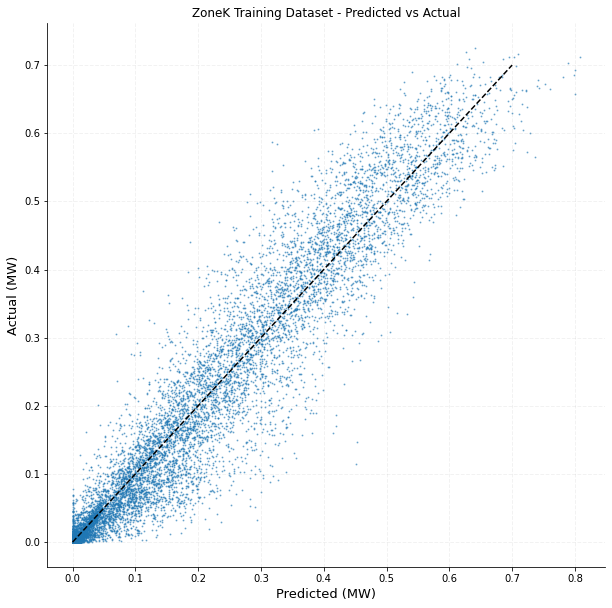

In [300]:
Fitted_Actual_Scatter(Train_Result, "Training")

In [ ]:
Fitted_Actual_Scatter_Hourly(Train_Result, 9, 'Training_baseline')

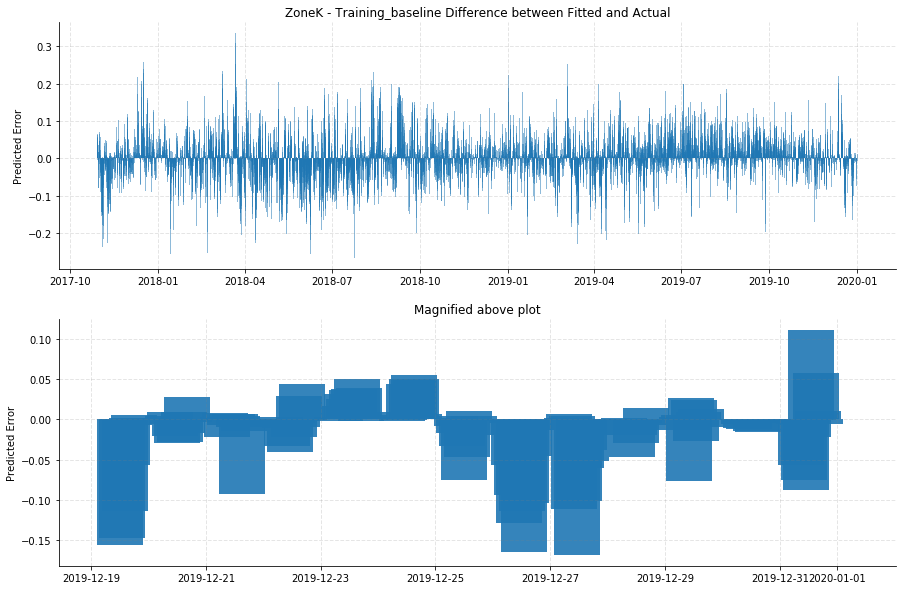

In [112]:
Prediction_Error_Bar(Train_Result, "Training_baseline")

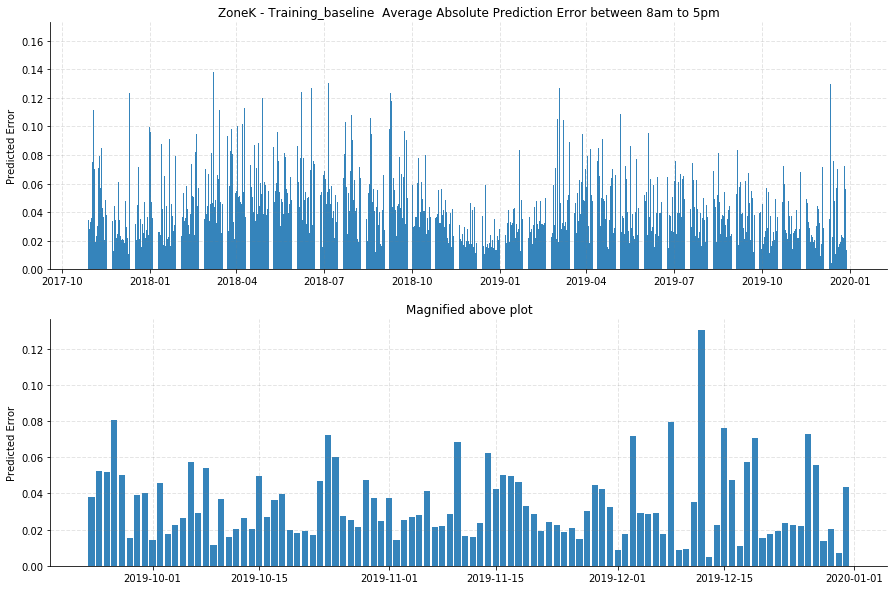

In [113]:
Daily_Average_Prediction_Error_Bar(Train_Result, "Training_baseline")

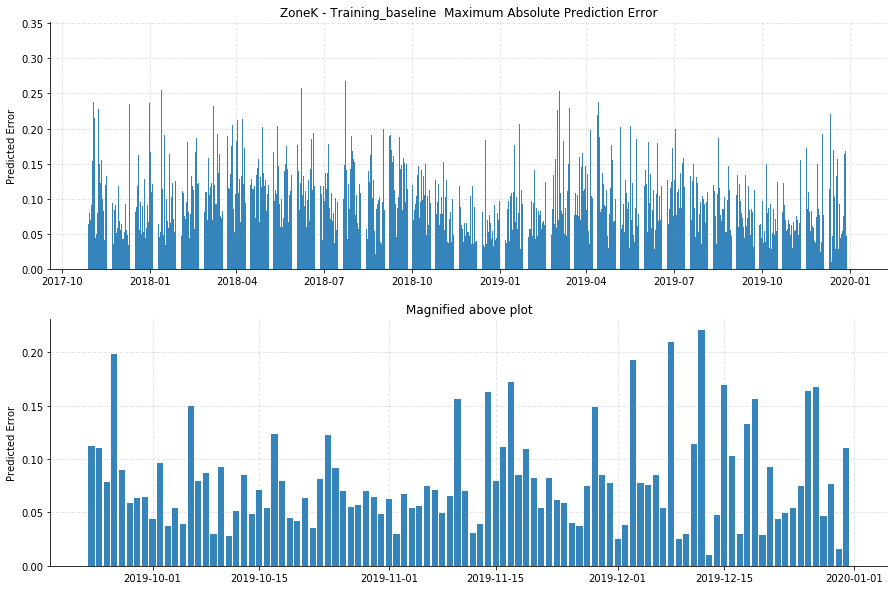

In [114]:
Daily_Max_Prediction_Error_Bar(Train_Result, "Training_baseline")

In [ ]:
ramping_plot(Train_Result, "Training", 1, 9, 15)

###### Testing

In [41]:
Test_Result = model_pred(test, models, 0, 23)

In [42]:
RMSE, MAPE, MAD = RMSE_MAPE_MAD(Test_Result)
dataset = "Testing"
print('%s RMSE = '%dataset, RMSE)

print('%s MAPE = '%dataset, MAPE,'%')

print('%s MAD for Forecasted BTM = '%dataset, MAD)

Testing RMSE =  0.0581
Testing MAPE =  14.91 %
Testing MAD for Forecasted BTM =  0.0412


In [308]:
df_RMSE, df_MAPE, df_MAD = RMSE_MAPE_MAD_DT_TABLE(Test_Result)
# writer = pd.ExcelWriter(r'Testing_Errors_Stat.xlsx', 
#                                 engine = 'xlsxwriter')
# df_RMSE.to_excel(writer, sheet_name = 'RMSE.xlsx')
# df_MAPE.to_excel(writer, sheet_name = 'MAPE.xlsx')
# df_MAD.to_excel(writer, sheet_name = 'MAD.xlsx')
# writer.save()

In [309]:
df_RMSE=df_RMSE.loc[list(range(6,21)),:]
df_MAPE=df_MAPE.loc[list(range(6,21)),:]
df_MAD=df_MAD.loc[list(range(6,21)),:]
dic_list = change_data_structure(df_RMSE, df_MAPE, df_MAD)
for key in dic_list:
    contour_plot(key, dic_list,'Test')

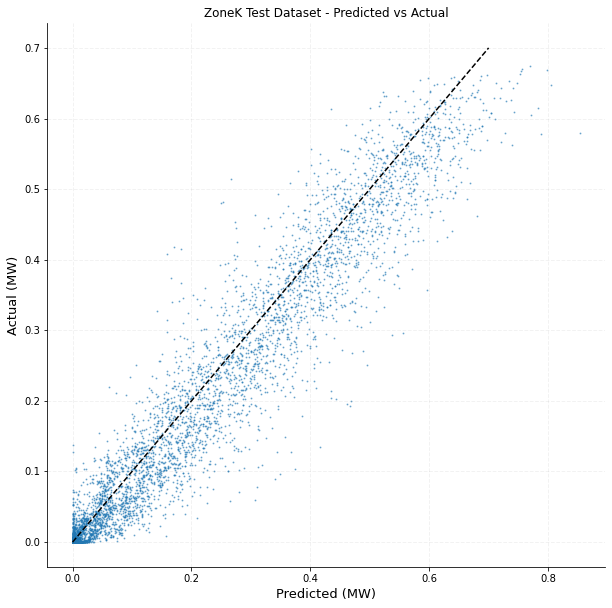

In [301]:
Fitted_Actual_Scatter(Test_Result, "Test")

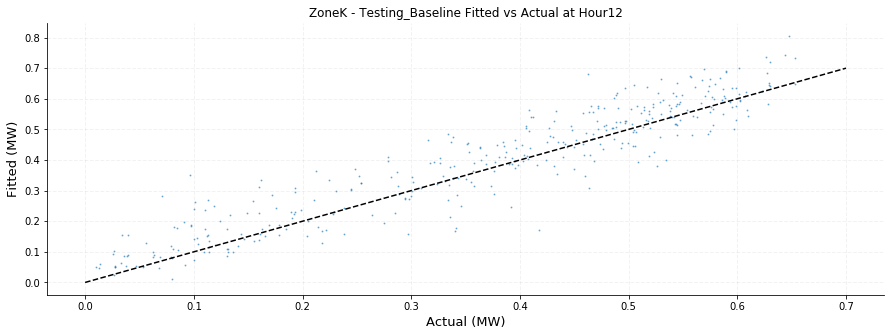

In [120]:
Fitted_Actual_Scatter_Hourly(Test_Result, 12, 'Testing_Baseline')

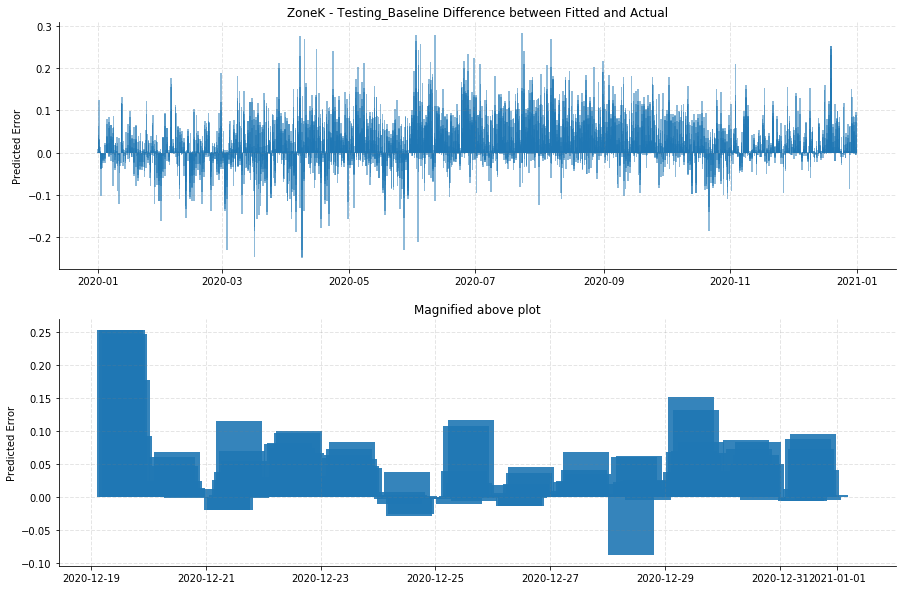

In [121]:
Prediction_Error_Bar(Test_Result, "Testing_Baseline")

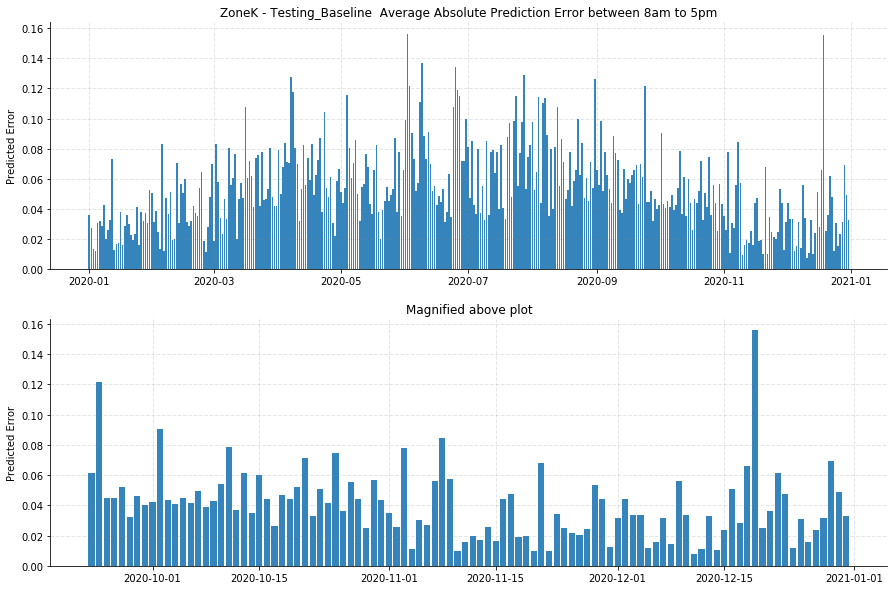

In [122]:
Daily_Average_Prediction_Error_Bar(Test_Result, "Testing_Baseline")

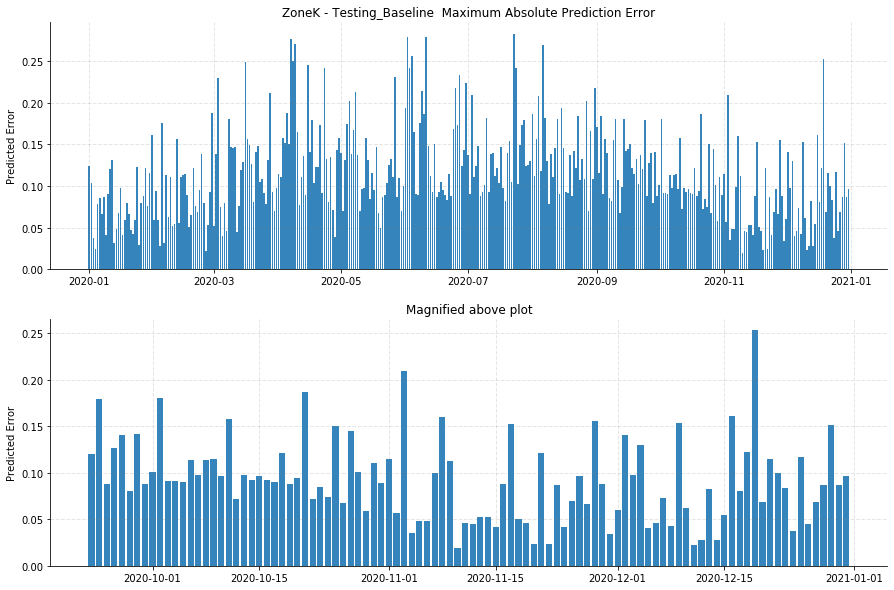

In [123]:
Daily_Max_Prediction_Error_Bar(Test_Result, "Testing_Baseline")

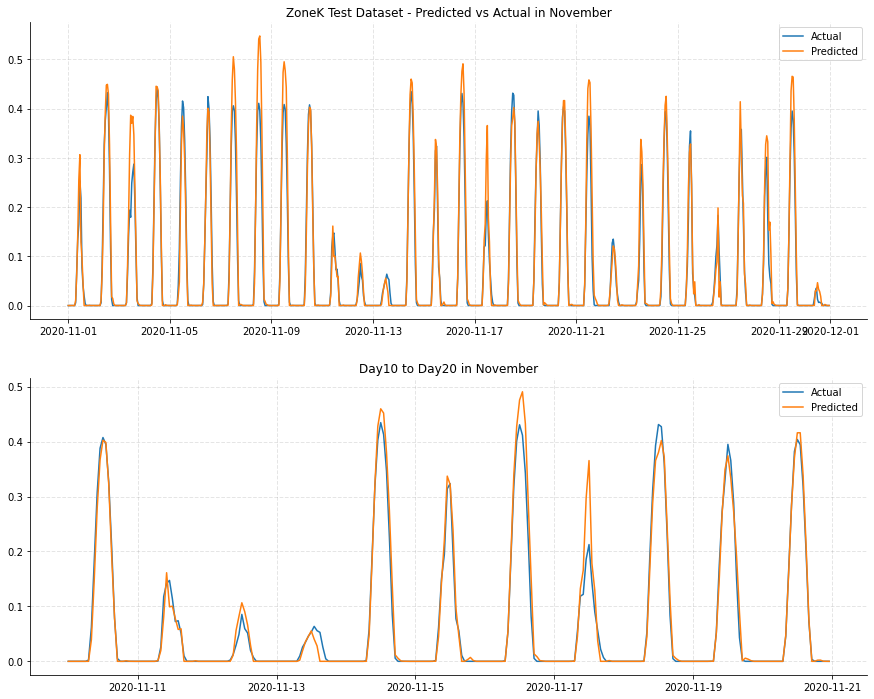

In [304]:
 daily_outlook(Test_Result, 'Test', 11)

In [ ]:
ramping_plot(Test_Result, "Test", 1, 9, 15)